In [28]:
#This is a toy model for learning DANN
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [29]:
import numpy as np
np.random.seed(42) # set the random seed for the reproducibility
import os
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"
from adapt.utils import make_classification_da
from adapt.feature_based import DANN
import scipy.stats as stats

In [30]:
num_classes = 2
input_size  = (3,)
num_epochs  = 100
batch_size  = 100

In [31]:
def create_sample_blobs(blob_centers, blob_stds, blob_num_samples, shuffle=True):
    """
    Create X blobs of N_x elements of shape (D_0, ..., D_d), picked from different 
    normal distributions N(m_x, s_x).
    Note: this is a simplified version of the method `sklearn.datasets.make_blobs`
    :param blob_centers:     Array of shape (X, D_0, ..., D_d) defining the distribution means m_x
    :param blob_stds:        Array of shape (X, D_0, ..., D_d) defining the distribution STDs s_x
    :param blob_num_samples: Array of shape (X,) defining the numbers N_x of elements per blob
    :param shuffle:          Flag to shuffle the elements from all blobs
    :return:                 x: Samples array of shape (N_0 + ... + N_x, D_0, ..., D_d) 
                             y: Class array of shape (N_0 + ... + N_x,) 
    """
    num_blobs = len(blob_centers)
    input_size = len(blob_centers[0])
    x, y = [], []
    for i in range(num_blobs):
        x_i = np.random.normal(loc=blob_centers[i], scale=blob_stds[i], 
                               size=(blob_num_samples[i], input_size))
        y_i = [i] * blob_num_samples[i]
        
        x.append(x_i)
        y += y_i
    x = np.concatenate(x, axis=0)
    y = np.asarray(y)
    if shuffle:
        shuffled_indices = np.random.permutation(len(y))
        x, y = x[shuffled_indices], y[shuffled_indices]
    return x, y

In [32]:
num_source_samples_per_class = 500
num_source_samples = num_source_samples_per_class * num_classes

x_source, y_source = create_sample_blobs(
    blob_centers=[[0, 0, 0],  # center of blob for class 0
                  [2, 4, 4]], # center of blob for class 1
    blob_stds=[[.5, .5, .5],  # STD of blob for class 0
               [.5, .5, .5]], # STD of blob for class 01
    blob_num_samples=[num_source_samples_per_class] * num_classes)

C:\Users\nn437\AppData\Local\Temp\ipykernel_11740\1547651006.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


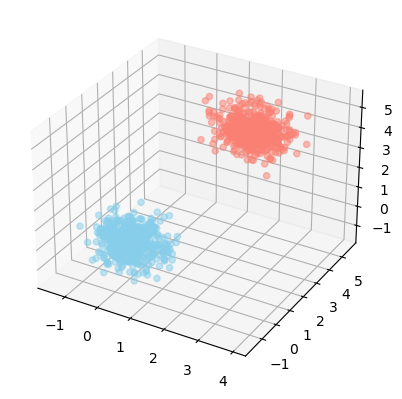

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_source[..., 0], x_source[..., 1], x_source[..., 2], 
           c=[["skyblue", "salmon"][class_id] for class_id in y_source], 
           marker='o', s=20, alpha=.5)
fig.show()

C:\Users\nn437\AppData\Local\Temp\ipykernel_11740\240479228.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


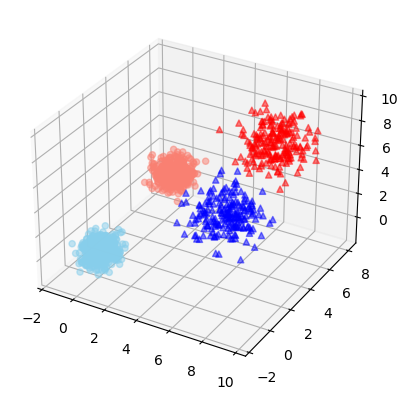

In [34]:
num_target_samples_per_class = 200
num_target_samples = num_target_samples_per_class * num_classes

x_target, y_target = create_sample_blobs(
    blob_centers=[[6, 3, 3], [7, 6, 7]], 
    blob_stds=[[1, 1, 1], [1, 1, 1]], 
    blob_num_samples= [num_target_samples_per_class] * num_classes)
def plot_3d_source_and_target_blobs(x_s, y_s, x_t, y_t=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_s[..., 0], x_s[..., 1], x_s[..., 2], 
               c=[["skyblue", "salmon"][class_id] for class_id in y_s], 
               marker='o', s=20, alpha=.5)
    ax.scatter(x_t[..., 0], x_t[..., 1], x_t[..., 2],
               c=[["b", "r"][class_id] for class_id in y_t] if y_t is not None else "grey", 
               marker='^', s=20, alpha=.5)
    fig.show()
    
plot_3d_source_and_target_blobs(x_source, y_source, x_target, y_target)

In [11]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

# Name of the final layer of our simple classifier:
class_preds_head_name = 'class_preds' 

inputs        = Input(shape=input_size) 
hidden1       = Dense(5, activation='relu')(inputs)
class_preds = Dense(num_classes, activation='softmax', name=class_preds_head_name)(hidden1)  

classification_model = Model(inputs=inputs, outputs=class_preds)
classification_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 5)                 20        
                                                                 
 class_preds (Dense)         (None, 2)                 12        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


In [35]:
import collections
from keras_custom_callbacks import SimpleLogCallback

classification_model.compile(optimizer="adam",
                             loss='sparse_categorical_crossentropy', 
                             metrics=[tf.metrics.SparseCategoricalAccuracy(name='acc')])


metrics_to_print = collections.OrderedDict([("source-loss", "loss"), 
                                            ("target-loss", "val_loss"),
                                            ("source-acc", "acc"), 
                                            ("target-acc", "val_acc")])
callbacks = [
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=5)
]

history = classification_model.fit(
    x_source, y_source, batch_size=batch_size, epochs=num_epochs, 
    validation_data=(x_target, y_target), 
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  1/100: source-loss = 0.001; target-loss = 0.352; source-acc = 1.000; target-acc = 0.923
Epoch  6/100: source-loss = 0.000; target-loss = 0.398; source-acc = 1.000; target-acc = 0.908
Epoch 11/100: source-loss = 0.000; target-loss = 0.448; source-acc = 1.000; target-acc = 0.892
Epoch 16/100: source-loss = 0.000; target-loss = 0.504; source-acc = 1.000; target-acc = 0.880
Epoch 21/100: source-loss = 0.000; target-loss = 0.561; source-acc = 1.000; target-acc = 0.868
Epoch 26/100: source-loss = 0.000; target-loss = 0.620; source-acc = 1.000; target-acc = 0.858
Epoch 31/100: source-loss = 0.000; target-loss = 0.673; source-acc = 1.000; target-acc = 0.850
Epoch 36/100: source-loss = 0.000; target-loss = 0.728; source-acc = 1.000; target-acc = 0.842
Epoch 41/100: source-loss = 0.000; target-loss = 0.782; source-acc = 1.000; target-acc = 0.822
Epoch 46/100: source-loss = 0.000; target-loss = 0.836; source-acc = 1.000; target-acc = 0.812
Epoch 51/100: source-loss = 0.000

13/13 [==============================] - 0s 1ms/step


C:\Users\nn437\AppData\Local\Temp\ipykernel_11740\240479228.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


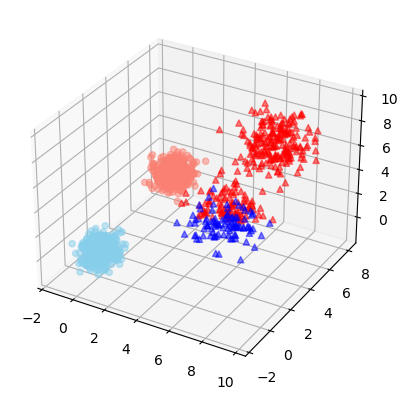

In [36]:
y_source_pred = classification_model.predict(x_source).argmax(1)
y_target_pred = classification_model.predict(x_target).argmax(1)

plot_3d_source_and_target_blobs(x_source, y_source_pred, x_target, y_target_pred)

C:\Users\nn437\AppData\Local\Temp\ipykernel_11740\240479228.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


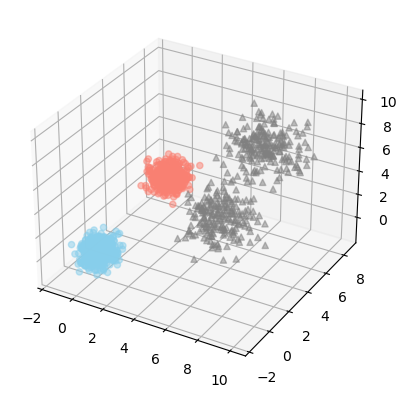

In [37]:
x_target_for_train, y_target_for_train = create_sample_blobs(
    blob_centers=[[6, 3, 3], [7, 6, 7]], 
    blob_stds=[[1, 1, 1], [1, 1, 1]], 
    blob_num_samples= [num_target_samples_per_class] * num_classes)

plot_3d_source_and_target_blobs(x_source, y_source, x_target_for_train, None)

In [38]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:         Input tensor
    :param hp_lambda: Hyper-parameter lambda (c.f. DANN paper), i.e. an updatable 
                      coefficient applied to the reversed gradient
    :return:          Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """
    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient

In [39]:
class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [40]:
hp_lambda = tf.Variable(1.0)
num_domains = 2 # "source" vs. "target"

# We create another simple classification sub-network:
domain_preds_head_name = 'domain_preds'
x = GradientReversal(hp_lambda)(hidden1)
x = Dense(12, activation='linear')(x)
x = Dense(5, activation='linear', name="do5")(x)
x = Activation("elu", name="do6")(x)
x = Dropout(0.5)(x)
domain_preds = Dense(num_domains, activation='softmax', name=domain_preds_head_name)(x)

domain_classification_model = Model(inputs=inputs, outputs=domain_preds)

In [53]:
combined_model = Model(inputs=inputs, outputs=[class_preds, domain_preds])

combined_model.compile(
    optimizer="adam",
    loss={
        class_preds_head_name:  'sparse_categorical_crossentropy',
        domain_preds_head_name: 'sparse_categorical_crossentropy'},
    loss_weights={
        class_preds_head_name:  1, 
        domain_preds_head_name: 1}, 
    metrics={
        class_preds_head_name:  tf.metrics.SparseCategoricalAccuracy(name='acc'),
        domain_preds_head_name: tf.metrics.SparseCategoricalAccuracy(name='acc')},
        weighted_metrics=[]

    # weight_metrics=True  # not implemented yet. see https://github.com/keras-team/keras/pull/7482
)

combined_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 5)            20          ['input_1[0][0]']                
                                                                                                  
 gradient_reversal_2 (GradientR  (None, 5)           1           ['dense[0][0]']                  
 eversal)                                                                                         
                                                                                                  
 dense_2 (Dense)                (None, 12)           72          ['gradient_reversal_2[0][0]

In [44]:
# We will create batches mostly composed of half source samples and half target samples:
half_batch_size = batch_size // 2

# Source training dataset composed of points and their labels:
source_dataset = tf.data.Dataset.from_tensor_slices((x_source, y_source))
source_dataset = source_dataset.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=num_source_samples_per_class * num_classes, count=num_epochs))
source_dataset = source_dataset.batch(half_batch_size)

# Target training dataset composed of points only:
target_dataset = tf.data.Dataset.from_tensor_slices(x_target_for_train)
target_dataset = target_dataset.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=num_target_samples_per_class * num_classes, count=-1))
# ^ we repeat the target data indefinitely, counting the epochs w.r.t the source data.
target_dataset = target_dataset.batch(half_batch_size)

# Combined training dataset:
training_dataset = tf.data.Dataset.zip((source_dataset, target_dataset))
print(training_dataset)

<ZipDataset element_spec=((TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>


In [45]:
def _prepare_data_for_dann_training(source_data, target_images,
                                    main_head_name='main_preds', domain_head_name='domain_preds'):
    
    source_images, source_labels = source_data
    
    # We check the number of samples for each domains (to cover edge cases, i.e., 
    # for the possibly smaller batch at the end of each epoch):
    num_source = tf.shape(source_images)[0]
    num_target = tf.shape(target_images)[0]
    
    # Full image batch:
    batch_images = tf.concat((source_images, target_images), axis=0)
    
    # Semantic segmentation label maps:
    # By default, the loss will be computed over the full batch, but we do not have GT
    # label maps for the target images. A simplistic solution is as follows:
    # 1) We create dummy GT label maps for the target images:
    target_labels = tf.zeros([num_target, *source_labels.shape[1:]], dtype=source_labels.dtype)
    batch_labels  = tf.concat((source_labels, target_labels), axis=0)
    # 2) We tell TF/Keras **not** to penalize the model for its predictions on the target
    # images/dummy labels, by assigning a weight = 0 to these elements of the batch:
    source_weight_per_sample = tf.tile([1], [num_source])
    target_weight_per_sample = tf.tile([0], [num_target])
    batch_sample_weights = tf.concat((source_weight_per_sample, target_weight_per_sample), 
                                     axis=0)
    
    # Note: this solution is simple but not optimal. Layer and loss operations will be applied
    # to half the batch even though the results won't be used for backpropagation. A better
    # solution to avoid useless computations would be to implement a custom loss aware it
    # should ignore the 2nd half of the batch. Or even better: to edit the model so that
    # only the source images are feed-forwarded to the classification head (e.g., adding a custom
    # layers dropping ~half the batch).
    
    # Domain classification ground-truth labels:
    # if we assign the label "1" to source data and "0" to target data, then we can simply reuse
    # the `batch_sample_weights` tensor:
    domain_labels = batch_sample_weights
    domain_sample_weights = tf.tile([1], [num_source + num_target])
    
    batch_targets = {main_head_name: batch_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: batch_sample_weights, 
                            domain_head_name: domain_sample_weights}

    return batch_images, batch_targets, batch_sample_weights
import functools

prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_training,
                                        main_head_name=class_preds_head_name, 
                                        domain_head_name=domain_preds_head_name)

training_dataset = training_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)
print(training_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), {'class_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'domain_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, {'class_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'domain_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})>


In [46]:

testing_dataset = tf.data.Dataset.from_tensor_slices((x_target, y_target))
testing_dataset = testing_dataset.batch(batch_size)

In [47]:
def _prepare_data_for_dann_validation(target_images, target_labels,
                                      main_head_name='main_preds', domain_head_name='domain_preds'):
    # The batch contains only validation/test images from the target domain. 
    # This time, we want to evaluate the main loss over these images, so we assign a normal loss
    # weight = 1 to each samples.
    num_samples = tf.shape(target_images)[0]
    
    # We want to evaluate over 
    loss_weights = tf.tile([1], [num_samples])
    
    domain_labels = tf.tile([0], [num_samples])
    
    batch_targets = {main_head_name: target_labels, 
                     domain_head_name: domain_labels}
    batch_sample_weights = {main_head_name: loss_weights, 
                            domain_head_name: loss_weights}

    return target_images, batch_targets, batch_sample_weights
prepare_for_dann_fn = functools.partial(_prepare_data_for_dann_validation,
                                        main_head_name=class_preds_head_name, 
                                        domain_head_name=domain_preds_head_name)

testing_dataset = testing_dataset.map(prepare_for_dann_fn, num_parallel_calls=4)
print(testing_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float64, name=None), {'class_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'domain_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None)}, {'class_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'domain_preds': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})>


In [54]:
import math
train_steps_per_epoch = math.ceil(num_source_samples / half_batch_size)
test_steps_per_epoch  = math.ceil(num_target_samples / batch_size)


# Note: we will display only a subset of the metrics, to keep the logs concise:
metrics_to_print = collections.OrderedDict([
    # ("comb-loss", "loss"), 
    ("c-loss", class_preds_head_name + "_loss"),
    ("d-loss", domain_preds_head_name + "_loss"), 
    ("c-acc", class_preds_head_name + "_acc"),
    ("d-acc", domain_preds_head_name + "_acc"),
    ("target c-acc", "val_" + class_preds_head_name + "_acc"),
    # ("target d-acc", "val_" + domain_preds_head_name + "_acc")
])
callbacks = [
    # Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1/2):
    SimpleLogCallback(metrics_to_print, num_epochs=num_epochs, log_frequency=5)
]

history = combined_model.fit(
    training_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=testing_dataset, validation_steps=test_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  1/100: c-loss = 0.001; d-loss = 0.686; c-acc = 0.744; d-acc = 0.547; target c-acc = 0.928
Epoch  6/100: c-loss = 0.001; d-loss = 0.687; c-acc = 0.744; d-acc = 0.525; target c-acc = 0.940
Epoch 11/100: c-loss = 0.001; d-loss = 0.687; c-acc = 0.753; d-acc = 0.526; target c-acc = 0.938
Epoch 16/100: c-loss = 0.001; d-loss = 0.686; c-acc = 0.743; d-acc = 0.545; target c-acc = 0.935
Epoch 21/100: c-loss = 0.001; d-loss = 0.687; c-acc = 0.743; d-acc = 0.523; target c-acc = 0.942
Epoch 26/100: c-loss = 0.001; d-loss = 0.687; c-acc = 0.751; d-acc = 0.527; target c-acc = 0.935
Epoch 31/100: c-loss = 0.001; d-loss = 0.690; c-acc = 0.740; d-acc = 0.505; target c-acc = 0.940
Epoch 36/100: c-loss = 0.001; d-loss = 0.689; c-acc = 0.758; d-acc = 0.521; target c-acc = 0.938
Epoch 41/100: c-loss = 0.001; d-loss = 0.691; c-acc = 0.748; d-acc = 0.507; target c-acc = 0.938
Epoch 46/100: c-loss = 0.000; d-loss = 0.691; c-acc = 0.734; d-acc = 0.526; target c-acc = 0.942
Epoch 51/100: